# Training convolutional variational autoencoder on MNIST


We would like to train a variational autoencoder based on [Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes."](https://arxiv.org/abs/1312.6114) paper (and CNNs) on MNIST, and then study the properties of the inner representation. We would also like to do transfer learning to see, if the representations are usefol for solving the classification task of notMNIST.

Original of the first part of the task comes from [here](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py)

## Preparations

In [1]:
!apt install graphviz
!pip install pydot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [2]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.optimizers import SGD, Adam, RMSprop

import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
# Just a function for fancy plotting based on matplotlib
# Nothing to do here.

def plot_results(models,
                 data,
                 batch_size=128):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
    """

    encoder, decoder = models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

   
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()


## Loading MNIST

In [4]:
# MNIST dataset loading
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshaping to become "tensors" instead of matrix
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

# "Normalizing" by greyscale
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print("X_train.shape:",x_train.shape)
print("X_test.shape:",x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
X_train.shape: (60000, 28, 28, 1)
X_test.shape: (10000, 28, 28, 1)


## Building the model

In [0]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
strides = 2
padding = 'same'
latent_dim = 2
epochs = 15

### Task: Read and understand the "The main trick"

The "heart" of all variational autoencoder methods lies the "reparametrization trick", which is realized by the following function.

Please study the mechanism below!

In [0]:
# Reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
#
# Reference
# Kingma, Diederik P., and Max Welling.
# "Auto-encoding variational bayes."
# https://arxiv.org/abs/1312.6114
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args

    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Building the encoder

In [8]:
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=strides,
               padding=padding)(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)

# ------- TASK ----------

# Please define a "fully connected" neural layer with the ReLU activation and 16 units
# The input should be x.
# Please try to figure out the output variable based on the next line - easiest solution.
# Please don't forget that there is a separate () for defining the layer and for calling it on a value!
# This layer does not need a name.
# The import for this is already handled ;-)

x = Dense(16, activation='relu')(x)

# These lines help to figure out the variable name before.
# Please observe the fact, that the processing "branches" here, 
# so there are _TWO_ things being calculated here in parallel
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


# ------- TASK ----------
#
# Use reparameterization trick to push the sampling out as output of the encoder
#
# Use Keras.layers.Lambda - which can execute the `sampling` function defined above in the prior cell  
# Lambda is already imported in the default namespace (see beginning of notebook)
# Input for the layer is the _list_ of prior two z_... outputs
# Please ensure, that the name of the sampling output is simply z 
# note that "output_shape" isn't necessary with the TensorFlow backend, 
# but for good riddance you can define it as a _tuple_ with only the latent dimension inside
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# We need z_mean, z_log_var for computing KL divergence later on, so we get this out of the model also,
# not just the sampled z itself.

encoder.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 128)  1280        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 7, 7, 256)    295168      conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 12544)        0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

### Building the decoder

In [10]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)


for i in range(2):

    # ------- TASK ----------
    # 
    # Define the deconvolution layers for the decoder model.
    # The design pattrn comes from the encoder.
    # Use the "transposed" layer 
    # (notice, it a a layer with separate name, already imported into the namespace !)
    # _ALL_ other parameters of the layer should conform to the encoder.
    # Continue to use functional style, pass on the "same" variable
    # _OBSERVE INDENTATION_ please!
    
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    
    filters //= 2
    
    
    
# ------- TASK ----------
#
# Define a final deconvolution layer (get inspiration from the task one above) 
# with _sigmoid_ activation for final output.
# filters should be 1, kernel size the one we used above, padding same, 
# name of the layer should be "decoder_output"
# Use functional style.
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        147520    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 203,905
Trainable params: 203,905
Non-trainable params: 0
_________________________________________________________________


### Task: The VAE itself

TASK: Observe the buildup of the composite loss function!

In [11]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Building the composite loss
# VAE loss = mse_loss + kl_loss 
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

optimizer = RMSprop()

vae.compile(optimizer=optimizer)
vae.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 497236    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         203905    
Total params: 701,141
Trainable params: 701,141
Non-trainable params: 0
_________________________________________________________________


## Training and results

In [14]:
# ------- TASK ----------
#
# Fit the vae model on x_train with epochs, batch_size defined at the beginning of the notebook
# Use validation data, a _tuple_ of x_test and None, since we have no y
# for syntax consult https://keras.io/models/model/#fit
vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))
vae.save_weights('vae_cnn_mnist.h5')



Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 15s 244us/step - loss: 50.0120 - val_loss: 43.6074
Epoch 2/15
60000/60000 [==============================] - 9s 149us/step - loss: 43.2611 - val_loss: 42.5001
Epoch 3/15
60000/60000 [==============================] - 9s 149us/step - loss: 41.8207 - val_loss: 40.5933
Epoch 4/15
60000/60000 [==============================] - 9s 149us/step - loss: 40.6726 - val_loss: 39.7775
Epoch 5/15
60000/60000 [==============================] - 9s 149us/step - loss: 39.8198 - val_loss: 39.2226
Epoch 6/15
60000/60000 [==============================] - 9s 150us/step - loss: 39.3207 - val_loss: 39.6433
Epoch 7/15
60000/60000 [==============================] - 9s 151us/step - loss: 38.8724 - val_loss: 38.3675
Epoch 8/15
60000/60000 [==============================] - 9s 152us/step - loss: 38.5576 - val_loss: 38.4633
Epoch 9/15
60000/60000 [=============

## Task: Observe the result

TASK: Please observe the resulting latent space, let's discuss!

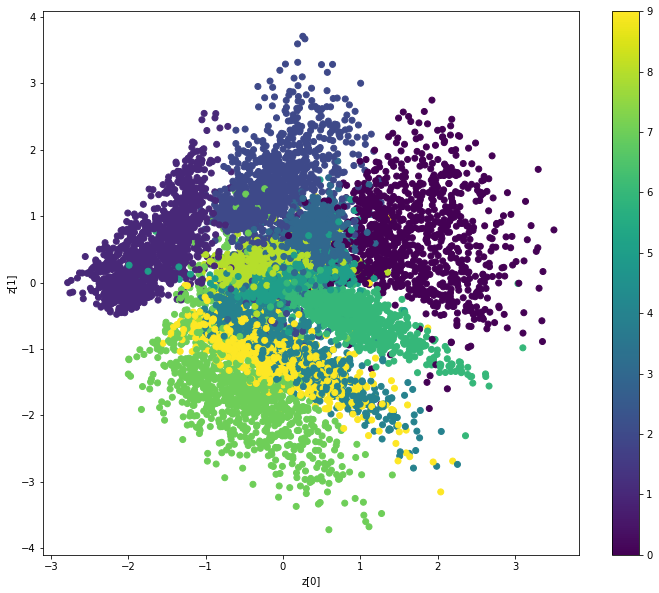

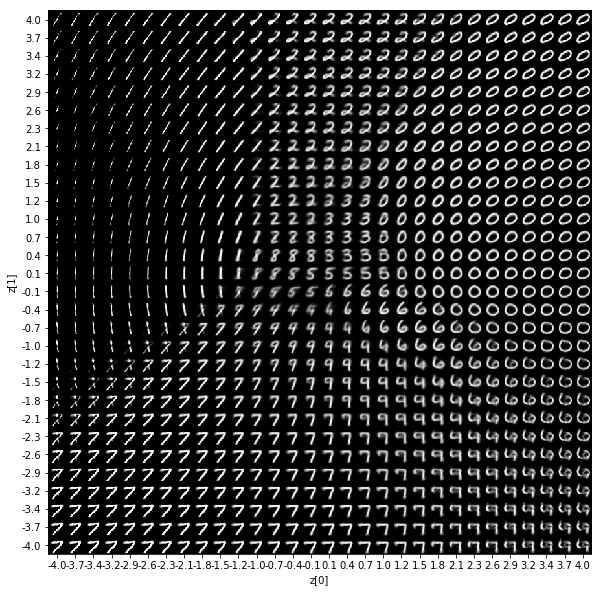

In [15]:
models = (encoder, decoder)
data = (x_test, y_test)

plot_results(models, data, batch_size=batch_size)


### Task: Play around with the representation!

TASK: give in two coordinates as data for the decoder, and observe the result!

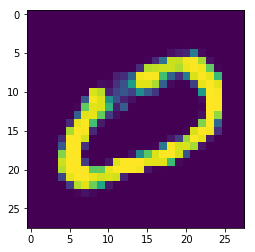

In [28]:
data = [11,11]


z_sample = np.array([data])
x_decoded = decoder.predict(z_sample)

plt.imshow(x_decoded.reshape(image_size,image_size))
plt.show()


### We save the encoder model for transfer learning

In [0]:
encoder.save("encoder.h5")

# Transfer learning on notMNIST

## Loading the model

In [30]:
loaded_encoder = load_model("encoder.h5")

# ---- Optional task AFTER the notebook is finished ---
# You canget back to here...
#
# This would keep the encoder static. Worth a try what it does :-)
#for layer in loaded_encoder.layers:
#        layer.trainable = False


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Loading and normalizing the data

No task here

In [31]:
! wget https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/t10k-images-idx3-ubyte.gz
! wget https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/t10k-labels-idx1-ubyte.gz
! wget https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/train-images-idx3-ubyte.gz
! wget https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/train-labels-idx1-ubyte.gz


--2019-05-05 07:55:31--  https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/t10k-images-idx3-ubyte.gz
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davidflanagan/notMNIST-to-MNIST/master/t10k-images-idx3-ubyte.gz [following]
--2019-05-05 07:55:31--  https://raw.githubusercontent.com/davidflanagan/notMNIST-to-MNIST/master/t10k-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3172375 (3.0M) [application/octet-stream]
Saving to: ‘t10k-images-idx3-ubyte.gz.1’

t10k-images-idx3-ub 100%[===================>]   3.03M  --.-KB/s    in 0.08s   

2019-05-05 07:55:31 (37.1 MB

In [0]:
import os
import gzip

def load_NOTmnist(path, kind='train'):
    """Load MNIST data from `path`.
    """
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [0]:
train_images, train_labels = load_NOTmnist('.')
valid_images, valid_labels = load_NOTmnist('.', 't10k')

In [34]:
from keras.utils import np_utils
from keras.losses import categorical_crossentropy
from keras.layers import concatenate, Dropout


classes = 10


train_labels = train_labels.astype('int32')
train_labels = np_utils.to_categorical(train_labels, 10)

train_images = train_images.astype('float32') / 255.
train_images = train_images.reshape((-1, image_size, image_size, 1))

valid_labels = valid_labels.astype('int32')
valid_labels = np_utils.to_categorical(valid_labels, 10)

valid_images = valid_images.astype('float32') / 255.
valid_images = valid_images.reshape((-1, image_size, image_size, 1))


print("Loaded data X shape:", train_images.shape)
print("Loaded data Y shape:", train_labels.shape)


Loaded data X shape: (60000, 28, 28, 1)
Loaded data Y shape: (60000, 10)


## Task: Defining the model

TASK: Observe the definition of the model, especially:
- the call for the loaded model
- the concatenation of the encoder output
- the final softmax layer
- the metrics we use

In [35]:
inputs = Input(shape=input_shape, name='encoder_input')

latent = loaded_encoder(inputs) #trainable=False?? You can get back to this LATER in the optional task above...

concat = concatenate(latent[0:2])

x = Dense(100, activation="relu")(concat)

predictions = Dense(10, activation='softmax')(x)

discriminator = Model(inputs, predictions, name='discriminator')

discriminator.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
discriminator.summary()

plot_model(discriminator, show_shapes=True)

plt.show()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 497236      encoder_input[0][0]              
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 4)            0           encoder[1][0]                    
                                                                 encoder[1][1]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 100)          500         concatenate_2[0][0]              
__________

## Task: Training the model

TASK: Observe how the training progresses! Share your observations!

In [36]:
history = discriminator.fit(x=train_images, y=train_labels, batch_size=128, epochs=5, validation_data=(valid_images, valid_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.8199 - acc: 0.7389 - val_loss: 0.3258 - val_acc: 0.9053
Epoch 2/5
60000/60000 [==============================] - 4s 71us/step - loss: 0.4780 - acc: 0.8538 - val_loss: 0.2557 - val_acc: 0.9183
Epoch 3/5
60000/60000 [==============================] - 4s 71us/step - loss: 0.4198 - acc: 0.8701 - val_loss: 0.2392 - val_acc: 0.9277
Epoch 4/5
60000/60000 [==============================] - 4s 71us/step - loss: 0.3856 - acc: 0.8811 - val_loss: 0.2365 - val_acc: 0.9282
Epoch 5/5
60000/60000 [==============================] - 4s 71us/step - loss: 0.3582 - acc: 0.8890 - val_loss: 0.2235 - val_acc: 0.9326


In [0]:
assert max(history.history['val_acc'])>0.925 and len(history.history)<7